# 1 Import from pkl files

In [1]:
import joblib
import matplotlib.pyplot as plt

df_sales = joblib.load('df_sales.pkl')
df_product = joblib.load('df_product.pkl')
df_cities = joblib.load('df_cities.pkl')
df_forecast_revenue = joblib.load('df_forecast_revenue.pkl')

# 2 Data Profiling

In [2]:
# Sort the data using date in ascending way
df_sales = df_sales.sort_values(by='date', ascending=True)

### 2.1 Check the last 30 days, because it needs to be removed prior to data trasnform

In [3]:
import pandas as pd

df_sales['date'] = pd.to_datetime(df_sales['date'])

# Define the specific days to count records for
specific_days = [
    '2019-10-31', '2019-10-30', '2019-10-29', '2019-10-28', '2019-10-27', '2019-10-26', '2019-10-25',
    '2019-10-24', '2019-10-23', '2019-10-22', '2019-10-21', '2019-10-20', '2019-10-19', '2019-10-18',
    '2019-10-17', '2019-10-16', '2019-10-15', '2019-10-14', '2019-10-13', '2019-10-12', '2019-10-11',
    '2019-10-10', '2019-10-09', '2019-10-08', '2019-10-07', '2019-10-06', '2019-10-05', '2019-10-04',
    '2019-10-03', '2019-10-02', '2019-10-01'
]
specific_days = pd.to_datetime(specific_days)

# Filter the DataFrame for the specific days
df_sales_last_week = df_sales[df_sales['date'].isin(specific_days)]

# Count the number of records by day
records_by_day = df_sales_last_week.groupby('date').size().reset_index(name='record_count')

# Display the result
print(records_by_day)

         date  record_count
0  2019-10-01          9693
1  2019-10-02          9761
2  2019-10-03          9791
3  2019-10-04          9816
4  2019-10-05          9747
5  2019-10-06          9713
6  2019-10-07          9753
7  2019-10-08          9759
8  2019-10-09          9797
9  2019-10-10          9805
10 2019-10-11          9818
11 2019-10-12          9819
12 2019-10-13          9764
13 2019-10-14          9767
14 2019-10-15          9748
15 2019-10-16          9757
16 2019-10-17          9773
17 2019-10-18          9764
18 2019-10-19          9797
19 2019-10-20          9716
20 2019-10-21          9741
21 2019-10-22          9739
22 2019-10-23          9747
23 2019-10-24          9766
24 2019-10-25          9749
25 2019-10-26          9739
26 2019-10-27          9714
27 2019-10-28          9701
28 2019-10-29          9694
29 2019-10-30          9667
30 2019-10-31          9681


In [4]:
# Filter the DataFrame to exclude those specific days
df_sales = df_sales[~df_sales['date'].isin(specific_days)]

### 2.2 Create the pipeline and apply the transformation

In [5]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Custom transformers
class RenameColumn(BaseEstimator, TransformerMixin):
    def __init__(self, old_name, new_name):
        self.old_name = old_name
        self.new_name = new_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.rename(columns={self.old_name: self.new_name})
        return X

class FillNaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, value):
        self.columns = columns
        self.value = value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for column in self.columns:
            X[column] = X[column].fillna(self.value)
        return X
    
class ConvertToDateTime(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.column] = pd.to_datetime(X[self.column])
        return X
    
class FillNaWithMedian(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        self.medians = {column: X[column].median() for column in self.columns}
        return self
    
    def transform(self, X):
        for column, median in self.medians.items():
            X[column] = X[column].fillna(median)
        return X

# Define the pipeline
pipeline_sales = Pipeline(steps=[
    ('rename_column', RenameColumn('Unnamed: 0', 'ID')),
    ('fillna_sales', FillNaTransformer(['sales'], 0)),
    ('fillna_revenue', FillNaTransformer(['revenue'], 0)),
    ('fillna_stock', FillNaTransformer(['stock'], 0)),
    ('fillna_price', FillNaTransformer(['price'], 0)),
    ('fillna_promo_bin_1', FillNaTransformer(['promo_bin_1'], 'No promo bin 1')),
    ('fillna_promo_type_2', FillNaTransformer(['promo_type_2'], 'No promo type 2')),
    ('fillna_promo_bin_2', FillNaTransformer(['promo_bin_2'], 'No promo bin 2')),
    ('fillna_promo_discount_2', FillNaTransformer(['promo_discount_2'], 0)),
    ('fillna_promo_discount_type_2', FillNaTransformer(['promo_discount_type_2'], 0)),
    ('convert_date', ConvertToDateTime('date'))
])

# Transform the DataFrame
df_sales = pipeline_sales.fit_transform(df_sales)

# Define the pipeline
pipeline_product = Pipeline(steps=[
    ('fillna_product_length', FillNaWithMedian(['product_length'])),
    ('fillna_product_depth', FillNaWithMedian(['product_depth'])),
    ('fillna_product_width', FillNaWithMedian(['product_width'])),
    ('fillna_cluster_id', FillNaTransformer(['cluster_id'], 'No cluster')),
])

# Transform the DataFrame
df_product = pipeline_product.fit_transform(df_product)

pipeline_forecast_revenue = Pipeline(steps=[
    ('convert_date', ConvertToDateTime('Date'))
])

# Transform the DataFrame
df_forecast_revenue = pipeline_forecast_revenue.fit_transform(df_forecast_revenue)

In [6]:
# Sort the data using date in ascending way
df_sales = df_sales.sort_values(by=['date', 'ID'], ascending=True)
df_sales

,ID,store_id,product_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,1,S0002,P0001,2017-01-02,0.0,0.00,8.0,6.25,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
1,2,S0002,P0005,2017-01-02,0.0,0.00,11.0,33.90,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
2,3,S0002,P0011,2017-01-02,0.0,0.00,9.0,49.90,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
3,4,S0002,P0015,2017-01-02,1.0,2.41,19.0,2.60,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
4,5,S0002,P0017,2017-01-02,0.0,0.00,12.0,1.49,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8583757,8583758,S0143,P0694,2019-09-30,0.0,0.00,7.0,7.50,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
8583758,8583759,S0143,P0709,2019-09-30,0.0,0.00,7.0,7.00,PR12,verylow,PR03,No promo bin 2,0.0,0
8583759,8583760,S0143,P0711,2019-09-30,0.0,0.00,5.0,12.90,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0
8583760,8583761,S0143,P0718,2019-09-30,0.0,0.00,14.0,23.75,PR14,No promo bin 1,PR03,No promo bin 2,0.0,0


In [7]:
df_product

,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
0,P0000,5.0,20.0,12.0,No cluster,H00,H0004,H000401,H00040105,H0004010534
1,P0001,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
2,P0002,22.0,40.0,22.0,cluster_0,H03,H0315,H031508,H03150800,H0315080028
3,P0004,2.0,13.0,4.0,cluster_3,H03,H0314,H031405,H03140500,H0314050003
4,P0005,16.0,30.0,16.0,cluster_9,H03,H0312,H031211,H03121109,H0312110917
...,...,...,...,...,...,...,...,...,...,...
694,P0744,2.0,7.0,7.0,No cluster,H03,H0311,H031108,H03110802,H0311080202
695,P0745,5.0,17.0,10.8,cluster_0,H02,H0209,H020908,H02090804,H0209080422
696,P0746,1.0,1.0,1.0,cluster_0,H03,H0314,H031407,H03140702,H0314070202
697,P0747,23.0,23.0,33.3,cluster_0,H01,H0107,H010701,H01070100,H0107010026


In [8]:
df_forecast_revenue

,Store,Date,fcst_revenue,WEEk
0,S0002,2019-10-01,739.0,40
1,S0002,2019-10-02,632.0,40
2,S0002,2019-10-03,597.0,40
3,S0002,2019-10-04,624.0,40
4,S0002,2019-10-05,999.0,40
...,...,...,...,...
1938,S0143,2019-10-27,93.0,44
1939,S0143,2019-10-28,93.0,44
1940,S0143,2019-10-29,93.0,44
1941,S0143,2019-10-30,92.0,44


In [9]:
df_cities

,store_id,storetype_id,store_size,city_id_old,country_id,city_code
0,S0036,ST04,21,C001,TURKEY,Denizli
1,S0005,ST04,19,C001,TURKEY,Denizli
2,S0104,ST04,47,C002,TURKEY,Ankara
3,S0068,ST03,14,C003,TURKEY,?zmir
4,S0086,ST03,12,C003,TURKEY,?zmir
...,...,...,...,...,...,...
58,S0040,ST04,42,C017,TURKEY,Kahramanmaras
59,S0046,ST04,26,C017,TURKEY,Kahramanmaras
60,S0102,ST04,27,C018,TURKEY,Erzurum
61,S0032,ST03,14,C019,TURKEY,Van


# 3 Plots after data profiling to keep understand the data 

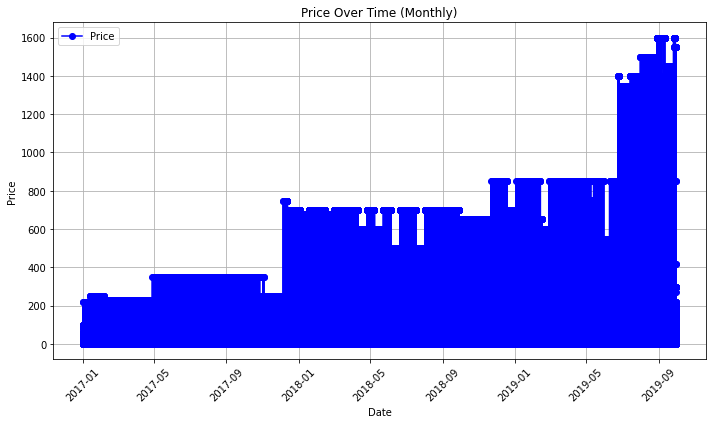

In [10]:

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_sales['date'], df_sales['price'], marker='o', linestyle='-', color='b', label='Price')
plt.title('Price Over Time (Monthly)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()  # Show legend if you have multiple lines

# Display the plot
plt.show()

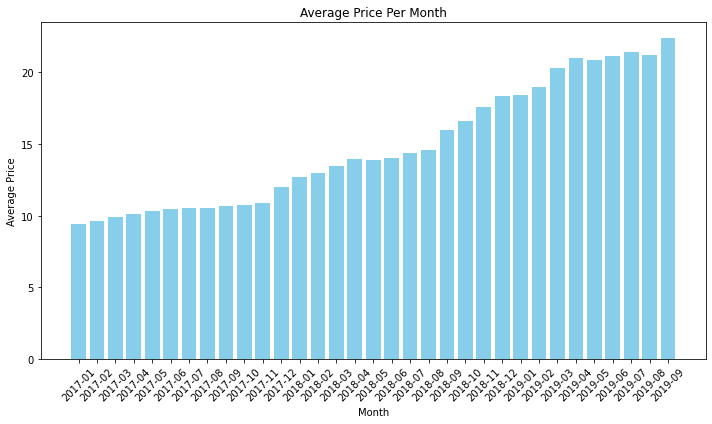

In [11]:
# Group by month and aggregate prices
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'price': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_price']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_price'], color='skyblue')
plt.title('Average Price Per Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

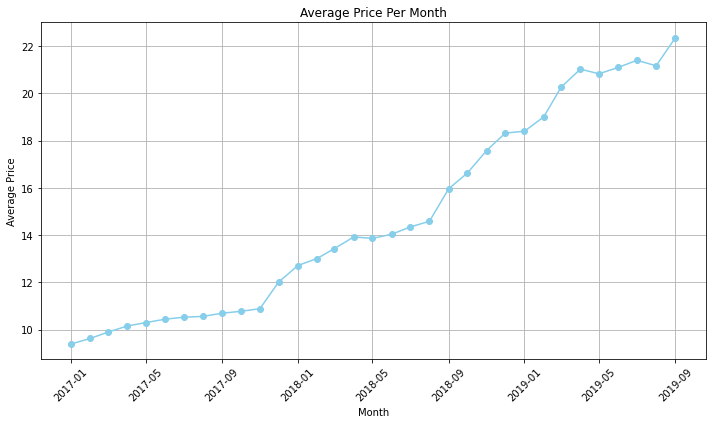

In [12]:
# Group by month and aggregate prices
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'price': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_price']

# Convert 'month' to datetime format for plotting
df_monthly_sales['month'] = df_monthly_sales['month'].dt.to_timestamp()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_sales['month'], df_monthly_sales['average_price'], marker='o', linestyle='-', color='skyblue')
plt.title('Average Price Per Month')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

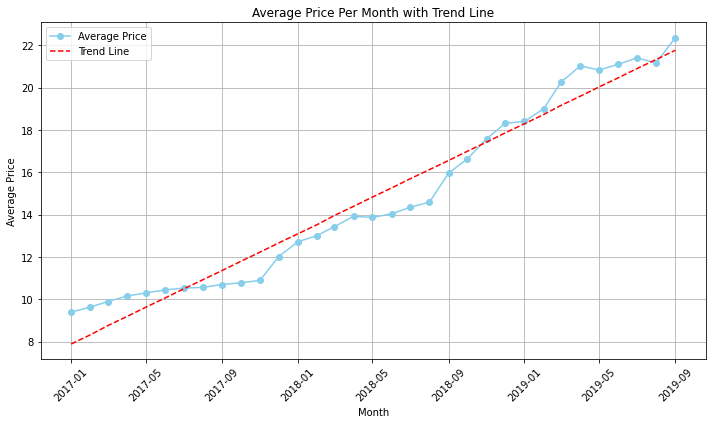

In [13]:
import numpy as np

# Group by month and aggregate prices
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'price': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_price']

# Convert 'month' to datetime format for plotting
df_monthly_sales['month'] = df_monthly_sales['month'].dt.to_timestamp()

# Calculate the number of months since the start of the data series
df_monthly_sales['month_num'] = (df_monthly_sales['month'].dt.year - df_monthly_sales['month'].dt.year.min()) * 12 + (df_monthly_sales['month'].dt.month - df_monthly_sales['month'].dt.month.min())

# Calculate trend line
z = np.polyfit(df_monthly_sales['month_num'], df_monthly_sales['average_price'], 1)
p = np.poly1d(z)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_monthly_sales['month'], df_monthly_sales['average_price'], marker='o', linestyle='-', color='skyblue', label='Average Price')
plt.plot(df_monthly_sales['month'], p(df_monthly_sales['month_num']), linestyle='--', color='red', label='Trend Line')
plt.title('Average Price Per Month with Trend Line')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

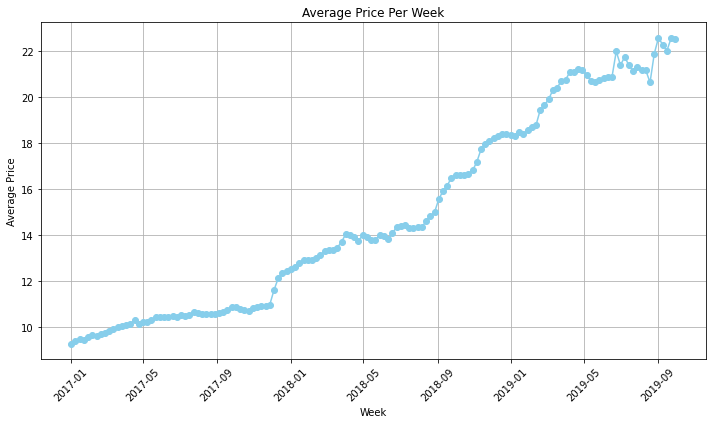

In [14]:
# Group by week and aggregate prices
df_weekly_sales = df_sales.groupby(df_sales['date'].dt.to_period('W')).agg({'price': 'mean'}).reset_index()

# Rename columns if needed
df_weekly_sales.columns = ['week', 'average_price']

# Convert 'week' to datetime format for plotting
df_weekly_sales['week'] = df_weekly_sales['week'].dt.to_timestamp()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_weekly_sales['week'], df_weekly_sales['average_price'], marker='o', linestyle='-', color='skyblue')
plt.title('Average Price Per Week')
plt.xlabel('Week')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Display the plot
plt.show()

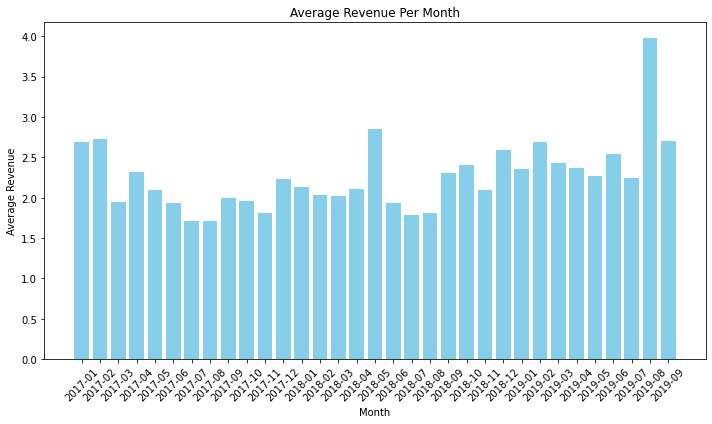

In [15]:
# Group by month and aggregate revenues
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'revenue': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_revenue']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_revenue'], color='skyblue')
plt.title('Average Revenue Per Month')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

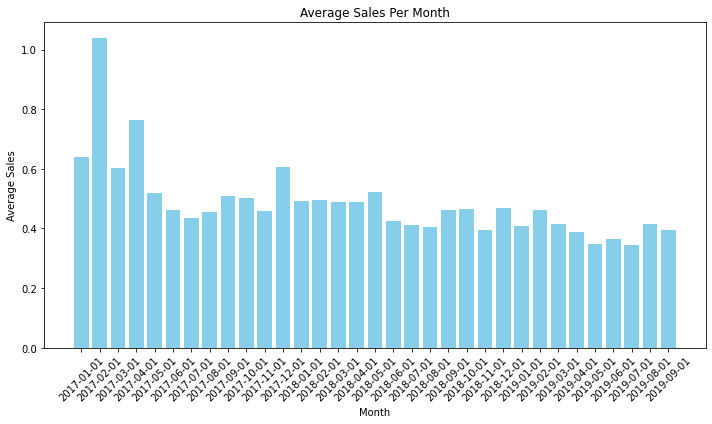

In [16]:
# Group by month and aggregate sales
df_monthly_sales = df_sales.groupby(df_sales['date'].dt.to_period('M')).agg({'sales': 'mean'}).reset_index()

# Rename columns if needed
df_monthly_sales.columns = ['month', 'average_sales']

# Convert 'month' to string format for consistent plotting
df_monthly_sales['month'] = df_monthly_sales['month'].dt.to_timestamp()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df_monthly_sales['month'].astype(str), df_monthly_sales['average_sales'], color='skyblue')
plt.title('Average Sales Per Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

### Add in temporary files to be possible use that in the following notebooks

In [17]:
import joblib

joblib.dump(df_sales, 'df_sales_silver.pkl')
joblib.dump(df_cities, 'df_cities_silver.pkl')
joblib.dump(df_product, 'df_product_silver.pkl')
joblib.dump(df_forecast_revenue, 'df_forecast_revenue_silver.pkl')
joblib.dump(df_sales_last_week, 'df_sales_last_week.pkl')

['df_sales_last_week.pkl']